In [1]:
import codecs
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

import nltk
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from keras.models import model_from_json
from sklearn.metrics import f1_score

repo_path = '/home/jamshid/codes/social-knowledge-analysis/'
sys.path.insert(0,repo_path)
from data import readers

%matplotlib inline

# Pretrained LSTM

In [2]:
data_dir = '/home/jamshid/codes/Certainty/BioCertainty/BioCertainty-master/data'
training_set = data_dir + '/training_set.csv'
model_json = data_dir+'/model.json'
model_h5 = data_dir+'/model.h5'

In [3]:
MAX_NB_WORDS = 6660
stopwords = nltk.corpus.stopwords.words('english')

In [4]:
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
fin = (codecs.open(training_set, "r",  encoding='utf8'))
maxlen = 0
for line in fin:
    sent = (line.strip().replace('\n', ' '))
    sent = [x for x in nltk.word_tokenize(sent) if x not in stopwords]
    texts.append(' '.join(sent))
    if len(sent) > maxlen:
        maxlen = len(sent)
fin.close()

In [5]:
MAX_SEQUENCE_LENGTH = maxlen

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [6]:
json_file = open(model_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [7]:
model = model_from_json(loaded_model_json)
model.load_weights(model_h5)
model.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [13]:
def Certainty(sents):

    # initial tokenizing the sentences
    sents = [np.array(nltk.word_tokenize(s.strip())) for s in sents]
    sents = [x[~np.isin(x,stopwords)] for x in sents]
    sents = [' '.join(x) for x in sents]

    # converting texts to sequences of integers and padding to a fixed-length vector
    seqs = tokenizer.texts_to_sequences(sents)
    pseqs = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH)
    pseqs = tf.convert_to_tensor(pseqs)

    # Evaluate model
    preds = model.predict_on_batch(pseqs)
    classes = np.argmax(preds,axis=1)

    return preds, classes


In [51]:
folder = '/home/jamshid/codes/Certainty/'

INPUT_FILE = folder+"Corpus/Complete_statements_training_set__ML_model.csv"

texts = []   # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
fin = codecs.open(INPUT_FILE, "r", encoding='utf8')
maxlen = 0
for line in fin:
    sent, certain = line.strip().split("\t")
    sent = [x for x in nltk.word_tokenize(sent) if x not in stopwords]
    texts.append(' '.join(sent))
    labels.append(certain)


In [80]:
texts = np.array(texts)
labels = np.uint8(np.array(labels))

In [95]:
preds = np.array([Certainty(x)[0][0] for x in texts])

In [105]:
f1_score(labels, preds+1, average=None)

array([0.93178893, 0.7976308 , 0.6252354 ])

# Zero-Short Classification

**Zero-shot** classification can be easily done through `huggingface`'s `pipeline`. The models offered in the pipeline consist of pretrained transformers that could run for particular tasks over a totally test samples coming from totally unseen data sets. Text classification is one example of these tasks, where the pretrained model could be used to infer the class labels of a given text. Most useful feature is that these class labels are an arbitrary set of strings and determined by the user. Hence, we can use such zero-shot classification to measure the uncertainty of any given sequence just by processing the way the language is used in there.

Not all transformers are available for zero-shot tasks. The main pretrained models that could be used with this `pipeline` are those with encoders, hence variants of BERT and BART architectures. The way zero-shot classification works is by converting the classification problem into a Next Sentence Prediction (NSP), where the model is to infer whether in a pair of given sentences the second one is a natural continuation of the first one. For any given sequence (sentence), the pipeline model will pair it with the auxiliary sentence `"This is [LABEL]"` where `[LABEL]` is one of the classification labels (e.g., `"certain"`). The output of the models would be a probability that the input sequence is related to this auxiliary one. The default model in the pipeline for this task is `bart-large-mnli`.

Here's more description of the [zero-shot classification pipeline](https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681).

In [2]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

In [34]:
def zero_shot_subuncert(sents):
    
    labels = ["certain", "uncertain"]
    
    R = classifier(sents,
                   candidate_labels=labels,
                   multi_class=False)
    scores = np.array([np.array(x['scores'])[np.array(x['labels'])=='uncertain'][0] for x in R])
    
    return scores

In [45]:
D = pd.read_csv('/home/jamshid/codes/data/SubjectiveCertainty/Sasha/augmented_lit_v1.csv.gz')
G = pd.read_csv('/home/jamshid/codes/data/SubjectiveCertainty/Sasha/augmented_gw_v1.csv.gz')

In [46]:
D.fillna('',inplace=True)
G.fillna('',inplace=True)

In [48]:
D['zero_shot_su']=0
G['zero_shot_su']=0
D.head()

,up,dn,pmid,pos,cdf_exp,title,abstract,sub_uncertainty,zero_shot_su
0,2,109,10970099,1,0.527944,Multiple forms of alpha2-macroglobulin from a ...,"Unlike mammals, bony fish possess multiple gen...",0.428571,0
1,2,213,1711509,1,0.296639,The effect of alpha 2 macroglobulin-proteinase...,Alpha-2-Macroglobulin (alpha 2M) is a major pl...,0.181818,0
2,2,213,18579803,1,0.296639,Copper is taken up efficiently from albumin an...,Ionic copper entering blood plasma binds tight...,0.200000,0
3,2,324,12443958,1,0.528730,The association between extrinsic activated pr...,"Recently, discussions have focused on the ques...",0.083333,0
4,2,324,18206217,1,0.528730,Treatment of endothelium with the chemotherapy...,Activated protein C (APC) is well-established ...,0.062500,0


In [50]:
from mat2vec.processing import process
    pr = process.MaterialsTextProcessor()

In [220]:
lb = 0

tqdm_list = tqdm(range(len(G)), position=0, leave=True)
while lb<=len(G):
    
    abst = [' '.join(pr.process(x)[0]) for x in G.iloc[lb:lb+500,].abstract if len(x)>0]
    sents = sum([list(filter(None, x.strip().split('.'))) for x in abst], [])
    nsents = [len(list(filter(None, x.strip().split('.')))) for x in abst]
    pmids = [G.iloc[lb+i].pmid for i,x in enumerate(G.iloc[lb:lb+500,].abstract) if len(x)>0]
    
    unc = Certainty(sents)[1]
    
    for i in range(len(nsents)):
        _lb = int(np.sum(nsents[:i]))
        _ub = int(np.sum(nsents[:i+1]))
        avg_unc = np.mean(unc[_lb:_ub])
        G.loc[G['pmid']==pmids[i],['sub_uncertainty']]= avg_unc
    
    lb += 500
    tqdm_list.update(min(500,len(G)-lb+500))

100%|██████████| 15494/15494 [04:01<00:00, 70.81it/s]

In [54]:
abst = [' '.join(pr.process(x)[0]) for x in G.iloc[:2].abstract if len(x)>0]
sents = sum([list(filter(None, x.strip().split('.'))) for x in abst], [])

In [232]:
G.to_csv('/home/jamshid/codes/data/SubjectiveCertainty/Sasha/augmented_gw_v1.csv.gz', 
         index=False,
         compression='gzip')

In [34]:
G = pd.read_csv('/home/jamshid/codes/data/SubjectiveCertainty/Sasha/augmented_gw_v1.csv.gz')
D = pd.read_csv('/home/jamshid/codes/data/SubjectiveCertainty/Sasha/augmented_lit_v1.csv.gz')
G.head()

,up,dn,pmid,pos,cdf_exp,title,abstract,sub_uncertainty
0,100,100,3141384,1,0.490085,Alteration of the carboxyl-terminal domain of ...,The ada gene of Escherichia coli K-12 encodes ...,0.111111
1,100,100,1924363,1,0.490085,A region of the Ada DNA-repair protein require...,The adaptive response of Escherichia coli prot...,0.125000
2,100,100,7937881,1,0.490085,The Ada protein acts as both a positive and a ...,The adaptive response of Escherichia coli prot...,0.333333
3,100,100,12013490,1,0.490085,Possible role of adenosine deaminase in vaso-o...,To describe several emerging concepts regardin...,0.571429
4,100,100,8986139,0,0.490085,Effect of deoxycoformycin and Val-boroPro on t...,CD26 and ecto-adenosine deaminase (ADA) are fo...,0.166667


/home/jamshid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jamshid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


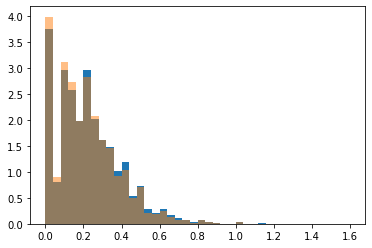

In [38]:
gsu = G[~G.pmid.duplicated()].sub_uncertainty
dsu = D[~D.pmid.duplicated()].sub_uncertainty
plt.hist(gsu, 40, normed=True);
plt.hist(dsu, 40, alpha=.5, normed=True);

In [32]:
R = classifier(
    ["This course could be about the Transformers library.", 
     "I suspect that it is this way.", 
     "I have no doubt that you are true",
     "these data suggest that GM may thus provide a beneficial effect which improves the microcirculatory environment and prevents tissue damage by inhibiting the activation of the vascular EC themselves"],
    candidate_labels=["certain", "uncertain"],
    multi_class=False
)

# Pretrained SciBERT

### Parsing the Abstracts

In [23]:
D = pd.read_csv('/home/jamshid/codes/data/SubjectiveCertainty/augmented_lit_v1.csv.gz')

In [39]:
D[~D['abstract'].isnull()][['pmid','abstract']].to_csv('/home/jamshid/codes/abstract-parser/ArgZoneTaggerV3.0/lit_v1.tsv', sep='\t', index=False, header=False)

Once the abstracts are saved in a tab-separated file format, we can run [Prabhakaran's](https://nlp.stanford.edu/pubs/prabhakaran2016rhetoricalroles.pdf) method on the abstracts to extract the findings stated in them (sentences classified as "RESULT"). We run this method in the bash by executing the following command:
```
java -jar ArgZoneTagger.jar config/Runner.properties lit_v1.tsv parse_lit_v1.tsv
```

In [2]:
A = pd.read_csv('/home/jamshid/codes/abstract-parser/ArgZoneTaggerV3.0/parsed_lit_v1.tsv',sep='\t',header=None)

In [3]:
# collecting out all the extracted finding sentences into a dictionary with keys as the distinct PMIDs
# and values as the extracted findings of them
results = {}
tqdm_list = tqdm(range(len(A)), position=0, leave=True)
for i in tqdm_list:
    row = A.iloc[i]
    rtype = row[0]
    if rtype=='ABSTRACT':
        # if we are not at the first iteration, the results should be updated
        if i>0:
            results[pmid] = pmid_results
        pmid = row[1]
        pmid_results = []
    else:
        if rtype=='RESULT':
            pmid_results += [row[1]]
    
    # in the last iteration, update the results for the last PMID
    if i==len(A)-1:
        results[pmid] = pmid_results

100%|██████████| 504218/504218 [00:42<00:00, 11780.49it/s]


In [36]:
D.insert(7,'findings',np.nan)

for pmid in results:
    D.loc[D.pmid==int(pmid), 'findings'] = ' '.join(results[pmid][:-1])

### Applying the pretrained ScieBERT

In [4]:
path = '/home/jamshid/codes/Certainty/certainty-estimator/'
sys.path.insert(0,path)

In [5]:
from certainty_estimator.predict_certainty import CertaintyEstimator

In [6]:
os.chdir('/home/jamshid/codes/Certainty/certainty-estimator/')
estimator = CertaintyEstimator('sentence-level')

In [7]:
estimator.model = estimator.model.to('cuda:0')
estimator.cuda = True

In [139]:
D['scibert_min'] = 0

In [147]:
tqdm_list = tqdm(results.items(), position=0, leave=True)
for pmid, findings in tqdm_list:
    if len(findings)==0:
        continue
    certs = estimator.predict(findings[:-1])
    D.loc[D.pmid==int(pmid), 'scibert_mean'] = np.mean(certs)

100%|██████████| 45110/45110 [10:35<00:00, 70.96it/s]


In [150]:
D[['scibert_mean','scibert_min']]

,scibert_mean,scibert_min
0,4.922029,4.474798
1,4.944395,4.614956
2,5.150705,4.995833
3,5.105231,4.906292
4,5.026688,4.926039
...,...,...
50472,4.924084,4.273334
50473,4.974516,4.874775
50474,5.025101,5.000871
50475,5.025627,4.978360
